# Tri par code NAF

On va essayer de regrouper les données par code NAF (*i.e.* par type d'entreprise), puis clusteriser séparèment et enfin d'afficher de manière sélective avec un `leaflet.ControlLayer`


In [1]:
import geopandas as gpd
from numpy.lib.financial import _pv_dispatcher
import pandas as pd
import numpy as np
import folium

from sklearn.cluster import KMeans

from shapely.geometry import Point, MultiPoint, Polygon

In [2]:
#Utilitaire

def swap_xy(geom):
    """
    Inverse les coordonnées de l'objet shapely.geometry.
    Utile pour passer objets shapely dans folium (la convention est inversée)
    :param geom: l'objet dont on veut inverser les coordonnées (Point, Polygon, MultiPolygon, etc.)
    :return: l'objet inversé
    """
    if geom.is_empty:
        return geom

    if geom.has_z:
        def swap_xy_coords(coords):
            for x, y, z in coords:
                yield (y, x, z)
    else:
        def swap_xy_coords(coords):
            for x, y in coords:
                yield (y, x)

    # Process coordinates from each supported geometry type
    if geom.type in ('Point', 'LineString', 'LinearRing'):
        return type(geom)(list(swap_xy_coords(geom.coords)))

    elif geom.type == 'Polygon':
        ring = geom.exterior
        shell = type(ring)(list(swap_xy_coords(ring.coords)))
        holes = list(geom.interiors)

        for pos, ring in enumerate(holes):
            holes[pos] = type(ring)(list(swap_xy_coords(ring.coords)))

        return type(geom)(shell, holes)

    elif geom.type.startswith('Multi') or geom.type == 'GeometryCollection':
        # Recursive call
        return type(geom)([swap_xy(part) for part in geom.geoms])

    else:
        raise ValueError('Type %r not recognized' % geom.type)


In [3]:
def nettoyer(df, reduce=False, threshold=1000):
    """
    Nettoie la DataFrame: enlève les na
    Si reduce=True, ne prend que les première données de la (Geo)DataFrame.
    La limite dans ce cas est fixée à threshold (qui vaut 1000 par défaut)
    """
    if reduce and df.size <= threshold:
        df = df[:threshold]

    return df.dropna(subset=["geometry"]).reset_index()

In [4]:
# On va maintenant commencer des tests : 

df = nettoyer(pd.read_json("../gis/input/base_sirene_shortened_json_cpp.json"))
len(df)

630080

In [5]:
df.head()

,index,apet700,libtefet,geometry
0,0,6820A,00-0salarié,"{'type': 'Point', 'coordinates': [2.348872, 48..."
1,1,4932Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.396281, 48..."
2,2,8551Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.297082, 48..."
3,3,4321A,NN-Unitésnonemployeuses,"{'type': 'Point', 'coordinates': [2.428486, 48..."
4,5,7022Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.283437, 48..."


In [6]:
len(set(df['apet700']))
# On a 682 types d'entreprises différents

682

In [7]:
# on va analyser les types les + présents : 

compte_par_type = {}
for NAF in sorted(list(set(df['apet700']))):
    compte_par_type[NAF] = 0

# df.loc[0,:]['apet700']
for i in df['index']:
    if i == 630080:
        break
    ligne_consideree = df.loc[i,:]
    compte_par_type[ligne_consideree['apet700']] += 1


In [8]:
import matplotlib.pyplot as plt

In [9]:
# plt.scatter(compte_par_type.keys(), compte_par_type.values())
# plt.show()

In [10]:
les_5_max = sorted(list(compte_par_type.values()))[-5:]
# sorted(list(compte_par_type.values()))
les_5_max

[18565, 22757, 24650, 36099, 64432]

In [11]:
liste_plus_grands = []
for key, value in compte_par_type.items():
    if value in les_5_max:
        liste_plus_grands.append((key, value))

    if len(liste_plus_grands) == 5:
        break
liste_plus_grands

[('4932Z', 18565),
 ('6820A', 24650),
 ('6820B', 64432),
 ('7022Z', 36099),
 ('9499Z', 22757)]

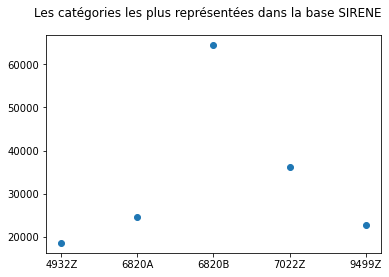

In [12]:
plt.scatter(
            [item[0] for item in liste_plus_grands],
            [item[1] for item in liste_plus_grands]
)
plt.suptitle("Les catégories les plus représentées dans la base SIRENE");

On va maintenant essayer de clusteriser les données de ces champs, les plus peuplés : 
```python
[('4932Z', 18565),
 ('6820A', 24650),
 ('6820B', 64432),
 ('7022Z', 36099),
 ('9499Z', 22757)]
 ```

In [13]:
# On va créer un table avec juste des apet700=='4932Z'

table_4932Z = df[df['apet700'] == '4932Z']
table_4932Z.shape


(19554, 4)

In [14]:
def clusterize(df, k, column_name="geometry", dict=False):
    """
    Clusterise à l'aide de l'algorithme des k-moyennes.

    A besoin d'une DataFrame contenant une colonne avec des Points (par défaut, son nom est geometry)
    Indiquer dict=True si jamais la colonne contenant les Points ne contient 
    pas l'objet Point (module shapely), mais un dictionnaire 
    (quand ça vient pas d'un GeoJSON en général)

    Attention, fait du en-place.
    Retourne trois choses :
    - la df rentrée, avec trois colonnes en plus:
            "cluster" (numéro du cluster), "centroids" (centre de masse correspondant)
            et "hulls" (enveloppe convexe)
            Ainsi, pour chaque point, on connaît les infos du cluster auquel il a été affecté
    - les centres de masse et les enveloppes convexes de chaque cluster (concrètement, une GeoDataFrame 
      avec comme index le numéro du cluster et comme colonnes les centres de masses et les enveloppes convexes)

    """

    #===========================================================
    # Commençons par faire le clustering et récupérer les centres
    # ==========================================================
    kmeans = KMeans(n_clusters=k, random_state=0)

    # Ceci contient des coordonnées (x, y) des points
    X = None

    if dict:
        a = pd.Series(df['geometry'].apply(lambda p: p["coordinates"][0]))
        b = pd.Series(df['geometry'].apply(lambda p: p["coordinates"][1]))

        X = np.column_stack((a, b))
    else:
        a = pd.Series(df[column_name].apply(lambda p: p.x))
        b = pd.Series(df[column_name].apply(lambda p: p.y))

        X = np.column_stack((a, b))

    # Cette DataFrame associe à chaque indice de ligne (ie à chaque point) 
    # son cluster, dans la colonne "cluster"
    clusters = gpd.GeoDataFrame(kmeans.fit_predict(X), columns=['cluster'], dtype=int)

    # Cette DataFrame associe à chaque numéro de cluster le centre de masse
    # correspondant, dans la colonne "centroids"
    centroids = pd.DataFrame(gpd.points_from_xy(kmeans.cluster_centers_[:, 0],
                                                kmeans.cluster_centers_[:, 1]),
                             columns=['centroids']
                            )

    # Désormais, on a ajouté à cette DataFrame une colonne centroids. 
    # Chaque point est donc associé à son cluster et le centre de masse correspondant
    clusters = clusters.join(centroids, how="left", on="cluster")

    # La DataFrame originale contient désormais deux colonnes en plus :
    # - "cluster"  : le numéro du cluster
    # - "centroids": le centre de masse correspondant
    df = df.join(clusters)

    # ================================================================
    # Désormais, on récupère les enveloppes convexes de chaque cluster
    # ================================================================

    # Tableau numpy temporaire. Il ne sert qu'à la création de la GeoDataFrame avec les enveloppes convexes
    temp_hulls = np.empty(k, dtype=Polygon)

    for n in range(k):
        # Cette DataFrame contient les points du cluster numéro n
        minidf = df.loc[df['cluster'] == n]

        # On calcule l'enveloppe convexe
        points = minidf.loc[:, column_name]
        if dict:
            points = gpd.points_from_xy(points.apply(lambda p: p["coordinates"][0]),
                                        points.apply(lambda p: p["coordinates"][1]))

            multi_point = MultiPoint(np.array(points, dtype=Point))
        else:
            multi_point = MultiPoint(points.array)
            
        hull = multi_point.convex_hull

        if type(hull) == Point:
            # S'il n'y a qu'un point dans le cluster, on ne peut pas créer de Polygon
            temp_hulls[n] = hull
        else:
            temp_hulls[n] = Polygon(hull)

    hulls = gpd.GeoDataFrame(gpd.GeoSeries(temp_hulls), columns=['hulls'])
    df = df.join(hulls, how='left', on='cluster')

    df_clusters = centroids.join(hulls)

    # ===================================================
    # RESULTATS
    # df contient trois colonnes en plus : 
    #       "cluster" (n° cluster), 
    #       "centroids" (centres) ,
    #       "hulls"
    # df_clusters associe à chaque numéro de cluster son centre et son enveloppe convexe
    # ==================================================

    return df, df_clusters

In [15]:
def save_to_map(df_clusters, map, nom="", couleur=""):
    """
    Sauvegarde les centres de gravité des clusters, ainsi que les enveloppes convexes, dans une carte Leaflet
    :param centroids: les centres de gravité (cf. deuxième sortie de la fonction clusterize)
    :param hulls: les enveloppes convesxes (cf. deuxième sortie de la fonction do_convex_hull)
    :param path: le chemin
    """

    if not couleur:
        couleur = 'cadetblue'

    centroids = df_clusters.loc[:, 'centroids']
    hulls = df_clusters.loc[:, 'hulls']

    feature_group = folium.FeatureGroup(name = nom).add_to(map)

    for k, point in enumerate(centroids):
        if point is not None:
            title = f"Centre de masse du cluster {k}"
           
            feature_group.add_child(
                folium.Marker(
                              location=[point.y, point.x], 
                              popup=title,
                              icon=folium.Icon(color=couleur, icon='info-sign')
                             )
            )

    for k, polygon in enumerate(hulls):
        title = f"Cluster {k}"
        if(type(polygon) == Point):
            # on est face à un cluster d'un seul point...
            feature_group.add_child(
                folium.Marker(
                              location=[polygon.y, polygon.x], 
                              popup=title,
                              icon=folium.Icon(color=couleur, icon='info-sign')
                             )
            )
        else:
            polygon = swap_xy(polygon)
            coords = polygon.exterior.coords
            feature_group.add_child(
                folium.Polygon(locations=coords, popup=title, color=couleur)
            )

    return map

In [16]:
codes_apet700_top5 = ['4932Z','6820A','6820B','7022Z','9499Z']

couleurs = ['cadetblue', 'lightblue', 'orange', 'darkred', 'black',
            'purple', 'gray', 'green', 'darkgreen', 'pink', 'lightgreen',
            'darkblue', 'white', 'blue', 'red']

map = folium.Map(location=[48.844952, 2.339193], 
                    zoom_start=10, 
                    tiles="OpenStreetMap"
                )

In [17]:
for i, NAF in enumerate(codes_apet700_top5):

    df_partial, df_clusters = clusterize(df[df['apet700']==NAF].reset_index(), 25, dict=True)

    map = save_to_map(df_clusters, map, nom=NAF, couleur=couleurs[i%len(couleurs)])

folium.LayerControl().add_to(map)

In [18]:
map